In [ ]:
!pip install kagglehub



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvasoundankar/global-housing-market-analysis-2015-2024")
path_1 = kagglehub.dataset_download("gpandi007/usa-housing-dataset")
print("Path to dataset files:", path)

import pandas as pd
# Load the dataset
global_data = pd.read_csv(path + "/global_housing_market_extended.csv")
us_data = pd.read_csv(path_1 + "/housing_train.csv")



In [ ]:
#Joining Mortgage Rate, Inflation Rate, GDP Growth, and Population Growth scraped from Bankrate & Fed Reserve
econ_data = pd.DataFrame({
    "YrSold": [2006, 2007, 2008, 2009, 2010],
    "Mortgage Rate (%)": [6.41, 6.34, 6.03, 5.04, 4.69],
    "Inflation Rate (%)": [3.2, 2.8, 3.8, -0.4, 1.6],
    "GDP Growth (%)": [2.7, 1.8, -0.1, -2.5, 2.6],
    "Population Growth (%)": [0.89, 0.95, 0.99, 0.86, 0.88]
})

# Merge into US Dataset
us_data = us_data.merge(econ_data, on="YrSold", how="left")

In [5]:
# Get rid of NA values
us_data.isnull().sum().sort_values(ascending=False).head(10)

# Drop columns with too many missing values or little importance
cols_to_drop = ['PoolQC', 'MiscFeature']
us_data.drop(columns=cols_to_drop, inplace=True)

# Fill 'None' for features where missing means "doesn't exist"
none_fill_cols = [
    'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
    'GarageQual', 'GarageFinish', 'GarageCond'
]
us_data[none_fill_cols] = us_data[none_fill_cols].fillna('None')

# Impute LotFrontage using median by Neighborhood
us_data['LotFrontage'] = us_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)


In [6]:
# Total Bathrooms: full + half (each half bath = 0.5)
us_data['TotalBathrooms'] = (
    us_data['FullBath'] +
    0.5 * us_data['HalfBath'] +
    us_data['BsmtFullBath'] +
    0.5 * us_data['BsmtHalfBath']
)

# Total square footage: 1st + 2nd floor + basement
us_data['TotalSF'] = us_data['1stFlrSF'] + us_data['2ndFlrSF'] + us_data['TotalBsmtSF']

# Age of house when sold and time since remodel
us_data['HouseAge'] = us_data['YrSold'] - us_data['YearBuilt']
us_data['RemodelAge'] = us_data['YrSold'] - us_data['YearRemodAdd']

# Binary flags
us_data['HasBasement'] = (us_data['TotalBsmtSF'] > 0).astype(int)
us_data['HasGarage'] = (us_data['GarageArea'] > 0).astype(int)


In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
from itertools import product

# Drop unique identifier column (not useful for prediction)
df = us_data.drop(columns=["Id"])

# Define target variable (what we want to predict)
y = df["SalePrice"]

# Define input features (everything except the target)
X = df.drop(columns=["SalePrice"])

# Encode categorical columns into numerical values
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Fill missing values with 0 (basic approach)
X = X.fillna(0)

# Split dataset into training+validation and test sets (80% / 20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training+validation into training and validation sets (60% / 20%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# Define a grid of hyperparameters to test
param_grid = {
    'n_estimators': [100, 200],               # Number of trees in the forest
    'max_depth': [10, 20, None],              # Maximum depth of each tree
    'max_features': ['sqrt', 'log2', None],   # Number of features to consider at each split
    'min_samples_split': [2, 5],              # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2],               # Minimum samples needed at a leaf node
}

# Initialize tracking variables for the best model and lowest RMSE
best_rmse = float('inf')
best_model = None
best_params = None

# Loop over all combinations of hyperparameters using a brute-force grid search
for combo in product(*param_grid.values()):
    # Convert the combination tuple into a dictionary of hyperparameters
    params = dict(zip(param_grid.keys(), combo))
    
    # Initialize a Random Forest model with the current set of hyperparameters
    model = RandomForestRegressor(random_state=42, **params)
    
    # Fit the model on the training set
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    val_pred = model.predict(X_val)
    
    # Calculate RMSE on the validation predictions
    rmse = mean_squared_error(y_val, val_pred) ** 0.5
    
    # If this model has the lowest RMSE so far, save it as the best
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Print the best validation RMSE and the associated hyperparameters
print("Best Validation RMSE:", round(best_rmse, 2))
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set to estimate real-world performance
test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_pred) ** 0.5
print("Test RMSE:", round(test_rmse, 2))



Best Validation RMSE: 26768.62
Best Hyperparameters: {'n_estimators': 200, 'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 2}
Test RMSE: 30868.43


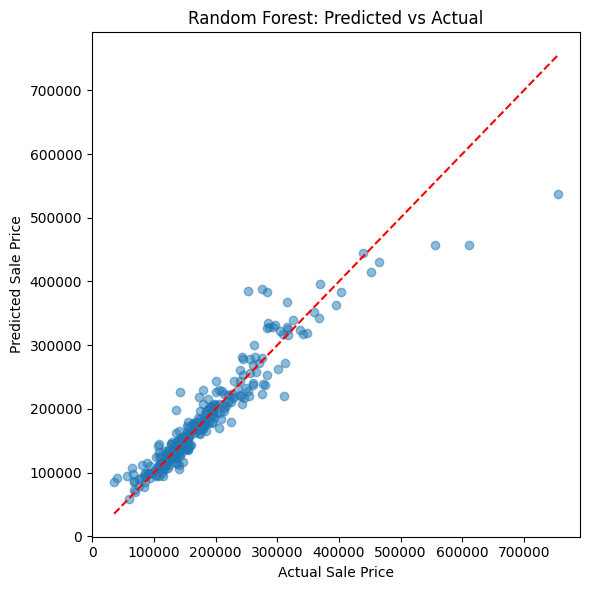

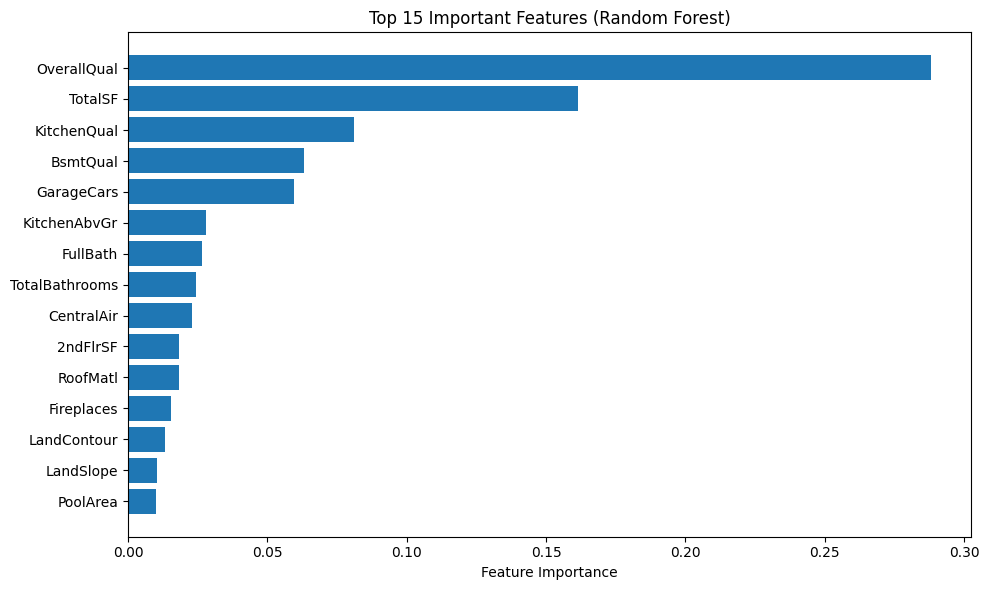

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot to compare predicted vs. actual sale prices
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred, alpha=0.5)  # Each point is a house
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line (perfect predictions)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Random Forest: Predicted vs Actual")
plt.tight_layout()
plt.show()

# Get feature importances from the trained Random Forest model
importances = best_model.feature_importances_

# Get the list of feature names
features = X.columns

# Sort features by importance and select the top 15
indices = np.argsort(importances)[::-1][:15]

# Create a horizontal bar chart of the top 15 most important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Most important feature appears at the top
plt.tight_layout()
plt.show()


In [8]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from itertools import product
import numpy as np

# Prepare the data
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Encode categorical variables
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Fill missing values with 0
X = X.fillna(0)

# Split into train+val and test sets (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation sets (60/20)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Set up tracking variables for best model
best_rmse = float('inf')
best_model = None
best_params = None

# Loop through all combinations of hyperparameters
for combo in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    
    model = xgb.XGBRegressor(random_state=42, **params)
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, val_pred) ** 0.5
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Evaluate best model on the test set
test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_pred) ** 0.5

print("Best Validation RMSE:", round(best_rmse, 2))
print("Best Hyperparameters:", best_params)
print("Test RMSE:", round(test_rmse, 2))


✅ Best Validation RMSE: 25538.83
✅ Best Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0}
✅ Test RMSE: 28228.9


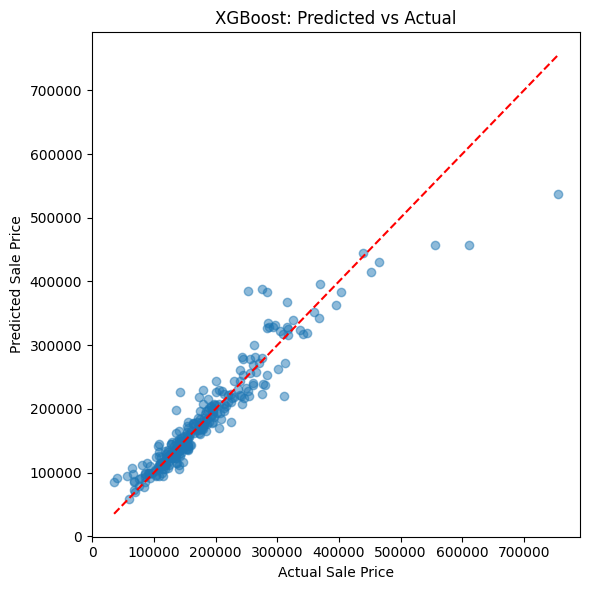

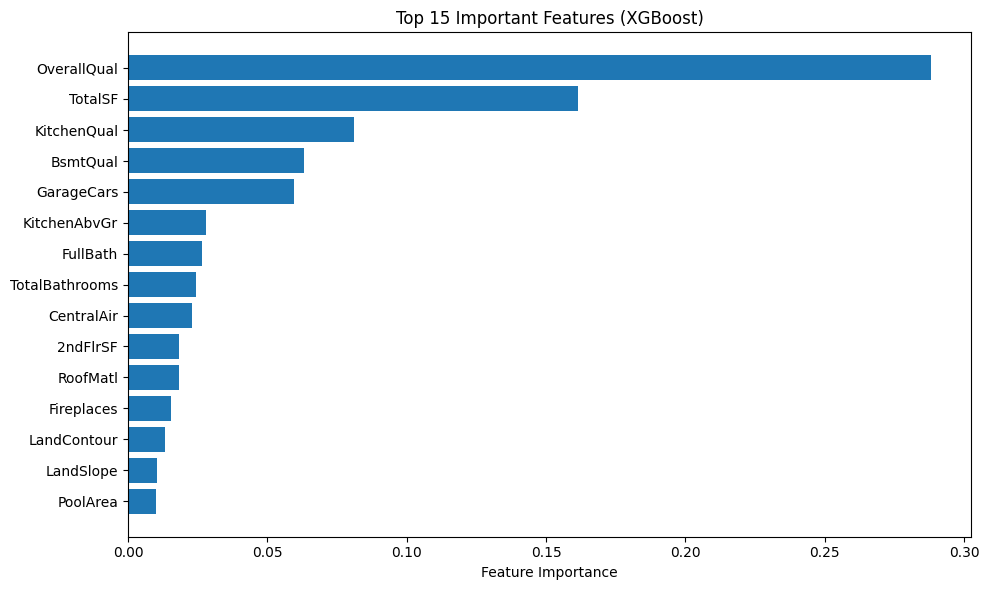

In [17]:
import matplotlib.pyplot as plt

# Generate scatter plot comparing actual and predicted prices
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred, alpha=0.5)

# Add diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Label axes and title
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("XGBoost: Predicted vs Actual")
plt.tight_layout()
plt.show()

# Get feature importances from the best XGBoost model
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1][:15]  # top 15 features

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (XGBoost)")
plt.gca().invert_yaxis()  # most important at the top
plt.tight_layout()
plt.show()